In [ ]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [ ]:
!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Felis_catus-cat_on_snow.jpg/1024px-Felis_catus-cat_on_snow.jpg" 

--2022-02-24 06:23:50--  https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Felis_catus-cat_on_snow.jpg/1024px-Felis_catus-cat_on_snow.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142413 (139K) [image/jpeg]
Saving to: ‘1024px-Felis_catus-cat_on_snow.jpg’

1024px-Felis_catus- 100%[===================>] 139.08K  --.-KB/s    in 0.03s   

2022-02-24 06:23:50 (4.78 MB/s) - ‘1024px-Felis_catus-cat_on_snow.jpg’ saved [142413/142413]



In [ ]:
IMAGE_PATH = "/content/cat.jpg"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [ ]:
def preprocess_image(image_path):
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [ ]:
%matplotlib inline
def plot_image(image, title=""):
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [ ]:
hr_image = preprocess_image(IMAGE_PATH)

Saved as Original Image.jpg


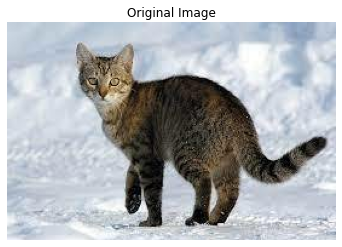

In [ ]:
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [ ]:
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 12.304208


Saved as Super Resolution.jpg


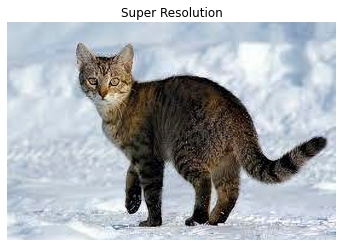

In [ ]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

In [ ]:
!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Felis_catus-cat_on_snow.jpg/1024px-Felis_catus-cat_on_snow.jpg" 
IMAGE_PATH = "/content/cat.jpg"

--2022-02-24 06:24:11--  https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Felis_catus-cat_on_snow.jpg/1024px-Felis_catus-cat_on_snow.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142413 (139K) [image/jpeg]
Saving to: ‘1024px-Felis_catus-cat_on_snow.jpg.1’

1024px-Felis_catus- 100%[===================>] 139.08K  --.-KB/s    in 0.04s   

2022-02-24 06:24:11 (3.86 MB/s) - ‘1024px-Felis_catus-cat_on_snow.jpg.1’ saved [142413/142413]



In [ ]:

def downscale_image(image):
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0,255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [ ]:
hr_image = preprocess_image(IMAGE_PATH)

In [ ]:
lr_image = downscale_image(tf.squeeze(hr_image))

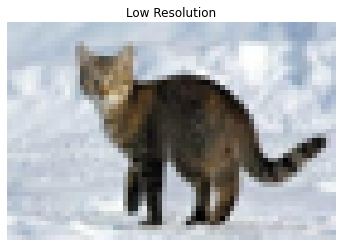

In [ ]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [ ]:
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 2.972561


In [ ]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0,255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR: 43.223976


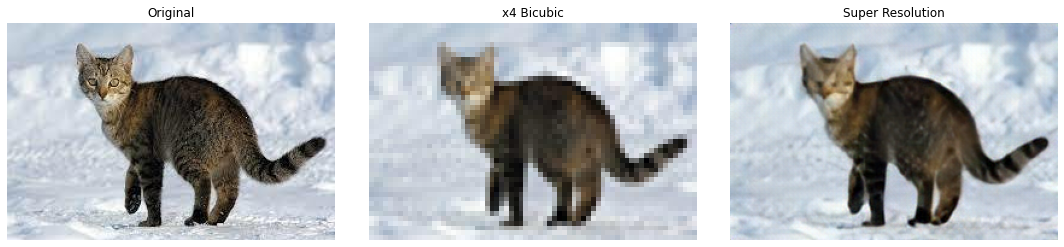

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)